# 权重衰减

在训练参数化机器学习模型时，*权重衰减*（weight decay）是最广泛使用的正则化的技术之一，它通常也被称为$L_2$*正则化*。
一种简单的方法是通过线性函数$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$中的权重向量的某个范数来度量其复杂性，
例如$\| \mathbf{w} \|^2$。
要保证权重向量比较小，最常用方法是将其范数作为惩罚项加到最小化损失的问题中。
将原来的训练目标*最小化训练标签上的预测损失*，调整为*最小化预测损失和惩罚项之和*。
现在，如果我们的权重向量增长的太大，我们的学习算法可能会更集中于最小化权重范数$\| \mathbf{w} \|^2$。
让我们回顾一下 :numref:`sec_linear_regression`中的线性回归例子。
我们的损失由下式给出：
$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

为了惩罚权重向量的大小，必须以某种方式在损失函数中添加$\| \mathbf{w} \|^2$，
实际上，我们通过*正则化常数*$\lambda$来描述这种权衡，这是一个非负超参数，我们使用验证数据拟合：

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$$

对于$\lambda = 0$，我们恢复了原来的损失函数。
对于$\lambda > 0$，我们限制$\| \mathbf{w} \|$的大小。


此外，为什么我们首先使用$L_2$范数，而不是$L_1$范数。
使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。
在实践中，这可能使它们对单个变量中的观测误差更为稳定。相比之下，$L_1$惩罚会导致模型将权重集中在一小部分特征上，而将其他权重清除为零。
这称为*特征选择*（feature selection），这可能是其他场景下需要的。

$L_2$正则化回归的小批量随机梯度下降更新如下式：

$$
\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}
$$

根据之前章节所讲的，我们根据估计值与观测值之间的差异来更新$\mathbf{w}$。
然而，我们同时也在试图将$\mathbf{w}$的大小缩小到零。
这就是为什么这种方法有时被称为*权重衰减*。
我们仅考虑惩罚项，优化算法在训练的每一步*衰减*权重。  
与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。
较小的$\lambda$值对应较少约束的$\mathbf{w}$，
而较大的$\lambda$值对$\mathbf{w}$的约束更大。

是否对相应的偏置$b^2$进行惩罚在不同的实践中会有所不同，
在神经网络的不同层中也会有所不同。
通常，网络输出层的偏置项不会被正则化。

## 高维线性回归

我们通过一个简单的例子来演示权重衰减。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集
**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，并使用一个只包含20个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现

下面我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。

### **初始化模型参数**

首先，我们将定义一个函数来随机初始化模型参数。

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### **定义$L_2$范数惩罚**

实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### **定义训练代码实现**

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。  
从 chap_linear以来，线性网络和平方损失没有变化，唯一的变化是损失现在包括了惩罚项。

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.267607688903809


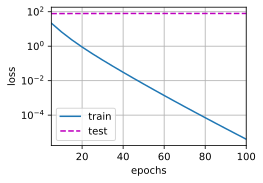

In [6]:
# 忽略正则化直接训练
train(lambd=0)

w的L2范数是： 0.024366630241274834


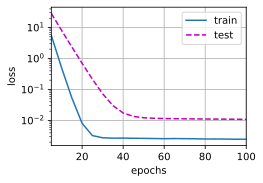

In [7]:
# 使用权重衰减
train(lambd=10)

## 简洁实现
在实例化优化器时直接通过`weight_decay`指定weight decay超参数。默认情况下，PyTorch同时衰减权重和偏移。
这里只为权重设置了`weight_decay`，所以偏置参数$b$不会衰减。

In [8]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.721906661987305


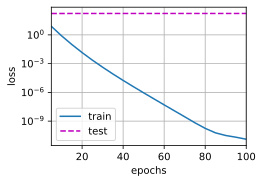

In [9]:
train_concise(0)

w的L2范数： 0.4361533522605896


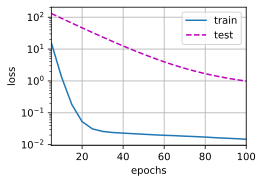

In [10]:
train_concise(3)